# Table of Contents
 <p><div class="lev1"><a href="#Warsztaty-modelowania-w-nanofizyce">Warsztaty modelowania w nanofizyce</a></div><div class="lev2"><a href="#Produkcja-animacji-do-prezentacji">Produkcja animacji do prezentacji</a></div>

#  Warsztaty modelowania w nanofizyce

## Produkcja animacji do prezentacji

**Paweł T. Jochym**

Zakład Komputerowych Badań Materiałów

Instytut Fizyki Jądrowej PAN, Kraków

----

Poniższy zeszyt służy do produkcji animacji wykorzystanych w prezentacji. Ponieważ proces kreślenia animacji jest raczej długotrwały warto go przeprowadzić w osobnym pliku, tak aby mieć pełną kontrolę nad jego przebiegiem, oraz nie powtarzać go za każdym razem gdy przeliczamy rachunki w prezentacji.

**Uwaga:** Wykonanie poniższego zeszytu zajmuje kilka godzin.


In [15]:
# Import potrzebnych modułów
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import pickle
import sys
from ase import Atoms
from ase.cluster import Cluster, Icosahedron
from ase import units as un
import ase.io
from IPython.core.display import Image
from numpy import array, sum, std, mean
import gzip

In [2]:
# Funkcje pomocnicze

def calc_velocities(a1,a2,dt):
    '''
    Wyliczenie prędkości atomów na podstawie pozycji a1, a2
    oraz odstępu czasu dt
    '''
    dx=(a2.get_positions()-a1.get_positions())
    c=Atoms(a2)
    tv=sum(c.get_cell(),axis=0)/2
    c.set_positions(dx)
    c.translate(tv)
    c.set_scaled_positions(c.get_scaled_positions())
    c.translate(-tv)
    return c.get_positions()/dt

def calc_kinen(tr,dt):
    '''
    Wyliczenie energii kinetycznej atomów w trajektorii tr 
    przy kroku czasowym dt.
    '''
    m=tr[0].get_masses()
    Ek=[m*sum(calc_velocities(a1,a2,dt)**2,axis=1)/2 for a1,a2 in zip(tr[:-1],tr[1:])]
    return Ek
    
def calc_temp(tr,dt):
    '''
    Wyliczenie chwilowej temperatury w trajektorii tr
    przy kroku czasowym dt
    '''
    eka=calc_kinen(tr,dt)
    ek=sum(eka,axis=-1)
    ekd=std(eka,axis=-1)
    n=len(tr[0].get_masses())
    c=n/(n-1)
    return 2*c*ek/(3*n*un.kB), 2*c*ekd/(3*un.kB)

def recenter(a):
    '''
    Normalizacja położenia nanocząstki do stałej pozycji środka masy
    '''
    c=Atoms(numbers=a.get_atomic_numbers(),
            positions=a.get_positions(),
            cell=a.get_cell(),
            pbc=a.get_pbc())
    c.translate((c.get_cell()/2).sum(axis=0)-c.get_center_of_mass())
    c.set_scaled_positions(c.get_scaled_positions())
    c.translate((c.get_cell()/2).sum(axis=0)-c.get_center_of_mass())
    c.set_scaled_positions(c.get_scaled_positions())
    return c


In [3]:
# Wczytanie danych wyliczonych przez program VASP przygotowanych wczesniej
md={}
for k,tr in pickle.load(gzip.open('data/md_PtFePt.p.gz','rb')).items():
    T=int(k.split('/')[-1][1:])
    md[T]=tr

# Lista temperatur dla których mamy wyliczoną trajektorię dynamiki molekularnej
print(sorted(md))

[150, 300, 500, 600, 700, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1350, 1400, 1425, 1450, 1500, 1600, 1700, 2000]


In [4]:
# Wstępne wyliczenie danych aby przyspieszyć generowanie kadrów
dat=[]
for T in sorted(md):
    dt,tr=md[T]
    epot=array([s.get_potential_energy() for s in tr])
    epot=((epot[:-1]+epot[1:])/2)
    ekin=sum(array(calc_kinen(tr,dt*un.fs)),axis=-1)
    etot=epot+sum(ekin,axis=-1)
    temp_v, temp_d=calc_temp(tr,dt*un.fs)
    atemp=mean(temp_v)
    dat.append([atemp,mean(epot-ekin),
                mean((etot-mean(etot))**2)/(un.kB*(atemp**2))])
dat=array(dat)

 2499:[1700,2000], T=2000K ofs=1850 frm= 649

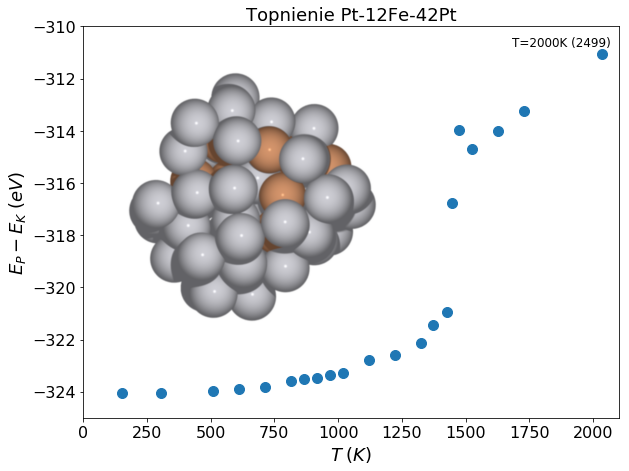

In [8]:
# Generowanie kadrów animacji

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

imgdir='img/'

def paint_frame(idx, fig, ax, iax):
    if fig is None:
        fig,ax=plt.subplots(figsize=(9.6,7.2))
        iax=plt.axes([0.12,0.3,0.5,0.5])
        
    else :
        #fig.clf()
        ax.cla()
        iax.cla()

    iax.axis('off')
    ax.set_xlim(0,2100)
    ax.set_xlabel('$T \; (K)$', fontsize=18)
    ax.set_ylabel('$E_P - E_K \; (eV)$', fontsize=18)
    ax.set_ylim(-325,-310)
    ax.set_title('Topnienie Pt-12Fe-42Pt',fontsize=18)

    edots,=ax.plot([],[],'o',ms=10)
    
    vl=ax.axvline(0,ymax=0.05,ls=':')
    lbl=ax.text(0.8,0.95,'T=',fontsize=12,transform=ax.transAxes)

    i=idx
    Tidx=abs(array(sorted(md))-i).argmin()
    T=sorted(md)[Tidx]
    if Tidx :
        Tp=sorted(md)[Tidx-1]
    else :
        Tp=-T
    trj=md[T]
    ofs=int((T+Tp)/2)
    edots.set_data(dat[:Tidx+1,0],dat[:Tidx+1,1])
    vl.set_xdata([i])
    
    lbl.set_text('T=%4dK (%4d)' % (T,idx))
    a=recenter(trj[1][i-ofs+200])
    print('\r %4d:[%4d,%4d], T=%4dK ofs=%4d frm=%4d' % (idx,Tp,T,T,ofs,i-ofs),end='')
    sys.stdout.flush()
    ase.io.write(imgdir+'md.pov', a, canvas_height=720,
            show_unit_cell=0, rotation='%.1fy,15x' % (i/4,),
            background='White', run_povray=True )
    iax.imshow(plt.imread(imgdir+'md.png'),
               aspect='equal',interpolation='bicubic', animated=True);
    del a
    return fig,ax,iax

fig=None
ax=None
iax=None
for i in range(700,2500):
    fig, ax, iax=paint_frame(i, fig, ax, iax)
    fig.savefig(imgdir+'anim_e_%04d.png' % i-700,dpi=100)

In [10]:
# Produkcja kadrów animacji nanocząstek o różnej temperaturze

for T in [150, 500, 1000, 1450, 2000]:
    for i,a in enumerate(md[T][1]):
        c=recenter(a)
        print('\r%4dK: %4d' % (T, i,),end='')
        sys.stdout.flush()
        ase.io.write('img/T%04d/md_T%04d_%04d.pov' % (T,T,i), c, canvas_height=720,
                show_unit_cell=0, rotation='%.1fy,15x' % (i/4,),
                background='White', run_povray=True )
    

2000K:  998

Przekształcenie kadrów w film w formacie webm przy użyciu krótkiego skryptu
powłoki. Operacje plikowe wygodniej jest prowadzić w języku powłoki systemu
operacyjnego. Dzięki "magicznemu" poleceniu `%%bash` cała komórka interpretowana 
jest jako skrypt powłoki.

In [ ]:
%%bash

# Produkcja filmu w formacie webm

ffmpeg -framerate 20 -i img/anim_e_%04d.png -s:v 960:720 -vf scale=-1:720 \
            -v 0 -vcodec libvpx -quality 'good' -y anim_e.webm

In [ ]:
%%bash

( cd img
    for t in T* ; do 
    (cd $t
        echo $t
        # Przeskalowanie kadrów do wspólnego rozmiaru
        for f in md_T*_*.png ; do 
            convert $f -resize 960x720 -gravity center -background "white" \
                -extent 960x720 amd.png 
            mv amd.png $f 
        done
        ffmpeg -framerate 20 -i md_${t}_%04d.png -s 960:720 -vf scale=-1:720 \
            -v 0 -y -vcodec libvpx -quality 'good' ../../anim_${t}.webm
    )
    done
)